In [2]:
import json

import numpy as np

import pandas as pd

from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

from adjustText import adjust_text

import scipy.stats as st
from sklearn.metrics import r2_score

In [3]:
# Configurazione opzioni Pandas e Matplotlib

pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

In [4]:
# Leggo il file di configurazione
with open('config/config.json') as f:
    config_data = json.load(f)

# Ottengo i percorsi dei file
file_path_vaccinazioni_covid = config_data['path_covid_19_france_vaccinations_age_sexe_dep']
file_path_andamento_dei_prezzi_al_consumo = config_data['path_economicref_france_indice_prix_consommation']
file_path_risultati_delle_elezioni_legislative_1_turno = config_data['path_elections_france_legislatives_2022_1er_tour_par_bureau_de_vote']
file_path_risultati_delle_elezioni_legislative_2_turno = config_data['path_elections_france_legislatives_2022_2nd_tour_par_bureau_de_vote']
file_path_risultati_delle_elezioni_presidenziali_1_turno = config_data['path_elections_france_presidentielles_2022_1er_tour_par_bureau_de_vote']
file_path_risultati_delle_elezioni_presidenziali_2_turno = config_data['path_elections_france_presidentielles_2022_2nd_tour_par_bureau_de_vote']
file_path_dati_sulla_disoccupazione = config_data['path_labouref_france_departement_quarter_jobseeker']
file_path_andamento_dei_prezzi_dei_carburanti = config_data['path_prix_des_carburants_j_1_001']
file_path_reddito_per_dipartimenti = config_data['path_departements_plus_riches_de_france']
file_path_inflazione = config_data['path_inflazione']

file_path_risultati_elezioni_presidenziali_1_turno = config_data['path_risultati_elezioni_presidenziali_1_turno']
file_path_risultati_elezioni_presidenziali_2_turno = config_data['path_risultati_elezioni_presidenziali_2_turno']


In [5]:
# Filtro dataset per regioni(solo regioni assegnate al nostro gruppo)

def filtra_dataset_per_regioni(file_path_dataset, sep=';', dtype={}):
    df_dataset = pd.read_csv(file_path_dataset, sep=sep, dtype=dtype)
    mask = (df_dataset['Nom Officiel Région'] == 'Hauts-de-France') | \
           (df_dataset['Nom Officiel Région'] == 'Grand Est') | \
           (df_dataset['Nom Officiel Région'] == 'Île-de-France') | \
           (df_dataset['Nom Officiel Région'] == 'Normandie') | \
           (df_dataset['Nom Officiel Région'] == 'Bretagne') | \
           (df_dataset['Nom Officiel Région'] == 'Bourgogne-Franche-Comté') | \
           (df_dataset['Nom Officiel Région'] == 'Centre-Val de Loire')
    df_dataset = df_dataset[mask]
    df_dataset.reset_index(drop=True, inplace=True)
    return df_dataset

In [6]:
# Definizione funzioni ausiliarie (Query)

def float_converter(s):
    s = s.replace(",", ".")
    return s

def float_converter_2(s):
    s = s.replace(",", "")
    return s


def percentage_calculator(row):
    if(row['espressi'] == 0):
        return 0
    else:
        return row['voti']/row['espressi']

    
def get_dipartimenti_min_max_perc_voti(df_dataset, cognome=None, min=False):
    """
        Funzione che calcola la maggiore o la minore percentuale di voti per un dato candidato
    """
    
    # raggruppo i dati sulle colonne 'nome_dipartimento' e 'cognome' e ottiengo la somma dei valori della colonna 'voti' e della colonna 'espressi'
    somma_voti_espressi = df_dataset.groupby(['nome_dipartimento', 'cognome'], as_index=False)[['voti','espressi']].sum()
    
    # filtro per cognome
    somma_voti_espressi = somma_voti_espressi[somma_voti_espressi['cognome'] == cognome]
    
    # calcolo la percentuale e ordino in maniera decrescente
    somma_voti_espressi['% voti_a_favore/voti_totali'] = somma_voti_espressi.apply(percentage_calculator, axis=1)
    percentuali = somma_voti_espressi.sort_values(by="% voti_a_favore/voti_totali",ascending=False)
    percentuali.reset_index(drop=True, inplace=True)
    
    # seleziono in base al valore di min i dipartimenti con percentuale maggiore o minore
    if min:
        df_query = percentuali[-20:]
    else:
        df_query = percentuali[:20]
    #display(df_query)
    lista_dipartimenti = df_query["nome_dipartimento"].values.tolist()
    display(lista_dipartimenti)
    return lista_dipartimenti


def differenza_presidenziali_legislative(candidati, partito):
    """
        Funzione che calcola la differenza in valore assoluto tra i voti espressi per uno o più candidati alle presidenziali 
        e i voti espressi per il relativo partito alle legislative
    """
    
    # tratta le colonne relative ai voti espressi di entrambi i dataframe come tipi numerici
    df_risultati_elezioni_presidenziali_1_turno['espressi'] = pd.to_numeric(df_risultati_elezioni_presidenziali_1_turno['espressi'])
    df_risultati_elezioni_legislative_1_turno['espressi'] = pd.to_numeric(df_risultati_elezioni_legislative_1_turno['espressi'])

    # filtra i dataframe sui candidati/partito di interesse
    df_presidenziali_candidati = df_risultati_elezioni_presidenziali_1_turno[df_risultati_elezioni_presidenziali_1_turno['cognome'].isin(candidati)]
    df_legislative_candidati = df_risultati_elezioni_legislative_1_turno[df_risultati_elezioni_legislative_1_turno['partito'] == partito]

    # somma i voti espressi per ogni dipartimento
    n_voti_presidenziali = df_presidenziali_candidati.groupby('nome_dipartimento')['espressi'].sum()
    n_voti_legislative = df_legislative_candidati.groupby('nome_dipartimento')['espressi'].sum()

    # merge dei due dataframe in base al dipartimento
    df_merged = pd.merge(n_voti_presidenziali, n_voti_legislative, on='nome_dipartimento', suffixes=('_presidenziali', '_legislative'))
    # aggiunge una colonna al dataset con il calcolo della differenza voti
    df_merged['differenza_voti'] = abs(df_merged['espressi_presidenziali'] - df_merged['espressi_legislative'])
    # ordina il dataframe per differenza voti decrescente
    df_merged = df_merged.sort_values(by='differenza_voti', ascending=False)
    df_merged.reset_index(inplace=True)
    #display(df_merged)

    # ottengo e stampo i 10 dipartimenti con differenza voti maggiore
    lista_dipartimenti = df_merged['nome_dipartimento'].values.tolist()[:10]
    display(lista_dipartimenti)
    return lista_dipartimenti

In [7]:
# Definizione funzioni ausiliarie (Correlazioni)

def correlation_calculator(x, y, x_label, y_label):
    """
        Funzione che calcola i coefficienti di correlazione per i vettori di dati inseriti,
        e disegna il grafico dei dati e della loro regressione lineare
    """
    
    slope, intercept, r, p, stderr = st.linregress(x, y)
    line = f'Retta di regressione: y = {intercept:.2f} + {slope:.2f}x'
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='o', label='Dati')
    ax.plot(x, intercept + slope * x, label=line)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.legend(facecolor='white')
    
    # Aggiungi le label ai punti
    #texts = []
    #for index, row in df_final.iterrows():
    #    texts.append(ax.text(x[index], y[index], row['nome_dipartimento'], ha='center', va='bottom'))
    
    # Ottimizza il posizionamento delle label
    #adjust_text(texts)
    
    r = x.corr(y, method='pearson')
    rho = x.corr(y, method='spearman')
    tau = x.corr(y, method='kendall')
    y_pred = intercept + slope * x
    y_true = y
    r2 = r2_score(y_true, y_pred)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    pearson_r = Line2D([0], [0], label=f'Indice di correleazione di Pearson      r={r:.2f}', marker='s', markersize=0.01, markeredgecolor='gray', markerfacecolor='gray', linestyle='')
    spearman_rho = Line2D([0], [0], label=f'Indice di correleazione di Spearman  ρ={rho:.2f}', marker='s', markersize=0.01, markeredgecolor='gray', markerfacecolor='gray', linestyle='')
    kendall_tau = Line2D([0], [0], label=f'Indice di correleazione di Kendall       τ={tau:.2f}', marker='s', markersize=0.01, markeredgecolor='gray', markerfacecolor='gray', linestyle='')
    determination_r2 = Line2D([0], [0], label=f'Coefficiente di determinazione         R²={r2:.2f}', marker='s', markersize=0.01, markeredgecolor='gray', markerfacecolor='gray', linestyle='')
    handles.extend([pearson_r, spearman_rho, kendall_tau, determination_r2])
    plt.legend(handles=handles)
    plt.show()

In [43]:
# Caricamento e cleaning dataset vaccinazioni_covid

df_vaccinazioni_covid = filtra_dataset_per_regioni(file_path_vaccinazioni_covid)
df_vaccinazioni_covid.rename(columns={"Date": "data", "Nombre de doses n°1": "numero_prime_dosi", "Nombre cumulé de doses n°1":"numero_cumulativo_prime_dosi", "Type de variable":"tipo_variabile","Valeur de la variable":"valore_variabile","Libellé de la variable":"etichetta_variabile", "Nom Officiel Département":"nome_dipartimento", "Code Officiel Région":"codice_regione", "Nom Officiel Région":"nome_regione", "Code Officiel Département":"codice_dipartimento", "Nombre de vaccinations complètes (doses n°2)":"numero_seconde_dosi", "Nombre de personnes vaccinées avec une dose de rappel (3e dose)":"numero_terze_dosi", "Nombre de personnes vaccinées avec une deuxième dose de rappel (4e dose)":"numero_quarte_dosi", "Nombre de doses de rappel bivalent":"numero_dosi_bivalenti", "Nombre de personnes ayant reçu une troisième dose de rappel":"numero_persone_terza_dose", "Nombre cumulé de vaccinations complètes (doses n°2)":"numero_cumulativo_seconde_dosi", "Nombre cumulé de personnes vaccinées avec une dose de rappel (3e dose)":"numero_cumulativo_terze_dosi", "Nombre cumulé de personnes vaccinées avec une deuxième dose de rappel (4e dose)":"numero_cumulativo_quarte_dosi", "Nombre cumulé de personnes vaccinées avec une dose de rappel bivalent":"numero_cumulativo_dosi_bivalenti", "Nombre cumulé de personnes ayant reçu une troisième dose de rappel":"numero_cumulativo_persone_terza_dose_richiamo", "Couverture vaccinale partielle (dose n°1)":"copertura_vaccinale_prima_dose", "Couverture vaccinale complète (dose n°2)":"copertura_vaccinale_seconda_dose", "Couverture vaccinale rappel/3e dose":"copertura_vaccinale_terza_dose", "Couverture vaccinale 2e rappel/4e dose":"copertura_vaccinale_quarta_dose", "Couverture vaccinale du rappel bivalent":"copertura_vaccinale_dose_bivalente", "Couverture vaccinale de la troisième dose de rappel":"copertura_vaccinale_terza_dose_richiamo"}, inplace=True)
df_vaccinazioni_covid.drop(['numero_persone_terza_dose','numero_cumulativo_persone_terza_dose_richiamo', 'copertura_vaccinale_terza_dose_richiamo'], axis=1, inplace=True)
new_ordered_columns = ["data","nome_regione","codice_regione","nome_dipartimento","codice_dipartimento","tipo_variabile","etichetta_variabile","valore_variabile","numero_prime_dosi","numero_seconde_dosi","numero_terze_dosi","numero_quarte_dosi","numero_cumulativo_prime_dosi","numero_cumulativo_seconde_dosi","numero_cumulativo_terze_dosi","numero_cumulativo_quarte_dosi","numero_dosi_bivalenti","numero_cumulativo_dosi_bivalenti", "copertura_vaccinale_prima_dose", "copertura_vaccinale_seconda_dose", "copertura_vaccinale_terza_dose", "copertura_vaccinale_quarta_dose", "copertura_vaccinale_dose_bivalente"]
df_vaccinazioni_covid = df_vaccinazioni_covid.reindex(columns=new_ordered_columns)
df_vaccinazioni_covid = df_vaccinazioni_covid.astype({"codice_dipartimento": "Int64"}, errors='ignore')
df_vaccinazioni_covid = df_vaccinazioni_covid.astype({"codice_dipartimento": str})
#df_vaccinazioni_covid.head(10)

In [ ]:
# Caricamento e cleaning dataset andamento_prezzi_consumo

df_andamento_prezzi_consumo = pd.read_csv(file_path_andamento_dei_prezzi_al_consumo, sep=';')
df_andamento_prezzi_consumo.rename(columns={"Période" : "periodo", "Indice" : "suggerimento", "Valeur": "valore","Code" : "codice","Type" : "tipo","Sous-type" : "sottotipo", "Base" : "base", "Population" : "popolazione", "Zone concernée" : "zona_interessata", "Code COICOP" : "codice_COICOP", "Désignation COICOP" : "designazione_COICOP", "Série arrêtée" : "serie_interrotta", "Référence INSEE" : "riferimento_INSEE"}, inplace=True)
#df_andamento_prezzi_consumo.head(10)

In [ ]:
# Caricamento e cleaning dataset risultati_elezioni_legislative_1_turno

df_risultati_elezioni_legislative_1_turno = filtra_dataset_per_regioni(file_path_risultati_delle_elezioni_legislative_1_turno, dtype={"Code du département": str, "Code de la commune": str, "Code du b.vote": str})
df_risultati_elezioni_legislative_1_turno.rename(columns={"Code du département" : "codice_dipartimento", "Libellé du département" : "nome_dipartimento", "Code de la circonscription" : "codice_della_circoscrizione", "Libellé de la circonscription" : "nome_della_circoscrizione", "Code de la commune" : "codice_del_comune", "Libellé de la commune" : "nome_del_comune", "Code du b.vote" : "codice_del_seggio_elettorale", "Inscrits" : "iscritti", "Abstentions" : "astenuti", "% Abs/Ins" : "% astenuti/iscritti", "Votants" : "votanti", "% Vot/Ins" : "% votanti/iscritti", "Blancs" : "bianche", "% Blancs/Ins" : "% bianche/iscritti", "% Blancs/Vot" : "% bianche/votanti", "Nuls" : "nulle", "% Nuls/Ins" : "% nulle/iscritti", "% Nuls/Vot" : "% nulle/votanti", "Exprimés" : "espressi", "% Exp/Ins" : "% espressi/iscritti", "% Exp/Vot" : "% espressi/votanti", "N°Panneau" : "pannello_numero", "Sexe" : "genere", "Nom" : "cognome", "Prénom" : "nome", "Nuance" : "partito", "Voix" : "voti", "% Voix/Ins" : "% voti/iscritti", "% Voix/Exp" : "% voti/iscritti", "Code Officiel EPCI" : "codice_ufficiale_EPCI", "Nom Officiel EPCI" : "nome_ufficiale_dello_EPCI", "Code Officiel Région" : "codice_ufficiale_regionale", "Nom Officiel Région" : "nome_ufficiale_regionale", "location" : "coordinate", "lib_du_b_vote" : "etichetta_del_seggio_elettorale", "scrutin_code" : "codice_scrutinio"}, inplace=True)
#df_risultati_elezioni_legislative_1_turno.head(10)

In [ ]:
# Caricamento e cleaning dataset risultati_elezioni_legislative_2_turno

df_risultati_elezioni_legislative_2_turno = filtra_dataset_per_regioni(file_path_risultati_delle_elezioni_legislative_2_turno, dtype={"Code du département": str, "Code de la commune": str, "Code du b.vote": str})
df_risultati_elezioni_legislative_2_turno.rename(columns={"Code du département" : "codice_dipartimento", "Libellé du département" : "nome_dipartimento", "Code de la circonscription" : "codice_della_circoscrizione", "Libellé de la circonscription" : "nome_della_circoscrizione", "Code de la commune" : "codice_del_comune", "Libellé de la commune" : "nome_del_comune", "Code du b.vote" : "codice_del_seggio_elettorale", "Inscrits" : "iscritti", "Abstentions" : "astenuti", "% Abs/Ins" : "% astenuti/iscritti", "Votants" : "votanti", "% Vot/Ins" : "% votanti/iscritti", "Blancs" : "bianche", "% Blancs/Ins" : "% bianche/iscritti", "% Blancs/Vot" : "% bianche/votanti", "Nuls" : "nulle", "% Nuls/Ins" : "% nulle/iscritti", "% Nuls/Vot" : "% nulle/votanti", "Exprimés" : "espressi", "% Exp/Ins" : "% espressi/iscritti", "% Exp/Vot" : "% espressi/votanti", "N°Panneau" : "pannello_numero", "Sexe" : "genere", "Nom" : "cognome", "Prénom" : "nome", "Nuance" : "partito", "Voix" : "voti", "% Voix/Ins" : "% voti/iscritti", "% Voix/Exp" : "% voti/iscritti", "Code Officiel EPCI" : "codice_ufficiale_EPCI", "Nom Officiel EPCI" : "nome_ufficiale_dello_EPCI", "Code Officiel Région" : "codice_ufficiale_regionale", "Nom Officiel Région" : "nome_ufficiale_regionale", "location" : "coordinate", "lib_du_b_vote" : "etichetta_del_seggio_elettorale", "scrutin_code" : "codice_scrutinio"}, inplace=True)
#df_risultati_elezioni_legislative_2_turno.head(10)

In [8]:
# Caricamento e cleaning dataset risultati_elezioni_presidenziali_1_turno

df_risultati_elezioni_presidenziali_1_turno = filtra_dataset_per_regioni(file_path_risultati_delle_elezioni_presidenziali_1_turno, dtype={"Code du département": str, "Code de la commune": str, "Code du b.vote": str})
df_risultati_elezioni_presidenziali_1_turno.rename(columns={"Code du département" : "codice_dipartimento", "Libellé du département" : "nome_dipartimento", "Code de la circonscription" : "codice_circoscrizione", "Libellé de la circonscription" : "nome_circoscrizione", "Code de la commune" : "codice_comune", "Libellé de la commune" : "nome_comune", "Code du b.vote" : "codice_seggio_elettorale", "Inscrits" : "iscritti", "Abstentions" : "astenuti", "% Abs/Ins" : "% astenuti/iscritti", "Votants" : "votanti", "% Vot/Ins" : "% votanti/iscritti", "Blancs" : "bianche", "% Blancs/Ins" : "% bianche/iscritti", "% Blancs/Vot" : "% bianche/votanti", "Nuls" : "nulle", "% Nuls/Ins" : "% nulle/iscritti", "% Nuls/Vot" : "% nulle/votanti", "Exprimés" : "espressi", "% Exp/Ins" : "% espressi/iscritti", "% Exp/Vot" : "% espressi/votanti", "N°Panneau" : "pannello_numero", "Sexe" : "genere", "Nom" : "cognome", "Prénom" : "nome", "Nuance" : "partito", "Voix" : "voti", "% Voix/Ins" : "% voti/iscritti", "% Voix/Exp" : "% voti/espressi", "Code Officiel EPCI" : "codice_EPCI", "Nom Officiel EPCI" : "nome_EPCI", "Code Officiel Région" : "codice_regione", "Nom Officiel Région" : "nome_regione", "location" : "coordinate", "lib_du_b_vote" : "etichetta_seggio_elettorale", "scrutin_code" : "codice_scrutinio"}, inplace=True)
new_ordered_columns = ["codice_regione","nome_regione","codice_dipartimento","nome_dipartimento","codice_EPCI", "nome_EPCI","codice_comune","nome_comune","codice_circoscrizione","nome_circoscrizione","codice_seggio_elettorale","iscritti","astenuti","% astenuti/iscritti","votanti","% votanti/iscritti","bianche","% bianche/iscritti","% bianche/votanti","nulle","% nulle/iscritti","% nulle/votanti","espressi","% espressi/iscritti","% espressi/votanti","pannello_numero","genere","cognome","nome","partito","voti","% voti/iscritti","% voti/espressi","coordinate","etichetta_seggio_elettorale","codice_scrutinio"]
df_risultati_elezioni_presidenziali_1_turno = df_risultati_elezioni_presidenziali_1_turno.reindex(columns=new_ordered_columns)
df_risultati_elezioni_presidenziali_1_turno['% voti/espressi'] = df_risultati_elezioni_presidenziali_1_turno['% voti/espressi'].map(float_converter)
df_risultati_elezioni_presidenziali_1_turno = df_risultati_elezioni_presidenziali_1_turno.astype({"codice_regione": "Int64", "codice_EPCI": "Int64", "codice_circoscrizione": "Int64", "% voti/espressi": np.float64}, errors='ignore')
df_risultati_elezioni_presidenziali_1_turno = df_risultati_elezioni_presidenziali_1_turno.astype({"codice_regione": str, "codice_EPCI": str, "codice_circoscrizione": str})
df_risultati_elezioni_presidenziali_1_turno.to_csv(file_path_risultati_elezioni_presidenziali_1_turno, index=False)
#df_risultati_elezioni_presidenziali_1_turno.head(10)

In [ ]:
# Caricamento e cleaning dataset risultati_elezioni_presidenziali_2_turno

df_risultati_elezioni_presidenziali_2_turno = filtra_dataset_per_regioni(file_path_risultati_delle_elezioni_presidenziali_2_turno, dtype={"Code du département": str, "Code de la commune": str, "Code du b.vote": str})
df_risultati_elezioni_presidenziali_2_turno.rename(columns={"Code du département" : "codice_dipartimento", "Libellé du département" : "nome_dipartimento", "Code de la circonscription" : "codice_circoscrizione", "Libellé de la circonscription" : "nome_circoscrizione", "Code de la commune" : "codice_comune", "Libellé de la commune" : "nome_comune", "Code du b.vote" : "codice_seggio_elettorale", "Inscrits" : "iscritti", "Abstentions" : "astenuti", "% Abs/Ins" : "% astenuti/iscritti", "Votants" : "votanti", "% Vot/Ins" : "% votanti/iscritti", "Blancs" : "bianche", "% Blancs/Ins" : "% bianche/iscritti", "% Blancs/Vot" : "% bianche/votanti", "Nuls" : "nulle", "% Nuls/Ins" : "% nulle/iscritti", "% Nuls/Vot" : "% nulle/votanti", "Exprimés" : "espressi", "% Exp/Ins" : "% espressi/iscritti", "% Exp/Vot" : "% espressi/votanti", "N°Panneau" : "pannello_numero", "Sexe" : "genere", "Nom" : "cognome", "Prénom" : "nome", "Nuance" : "partito", "Voix" : "voti", "% Voix/Ins" : "% voti/iscritti", "% Voix/Exp" : "% voti/espressi", "Code Officiel EPCI" : "codice_EPCI", "Nom Officiel EPCI" : "nome_EPCI", "Code Officiel Région" : "codice_regione", "Nom Officiel Région" : "nome_regione", "location" : "coordinate", "lib_du_b_vote" : "etichetta_seggio_elettorale", "scrutin_code" : "codice_scrutinio"}, inplace=True)
new_ordered_columns = ["codice_regione","nome_regione","codice_dipartimento","nome_dipartimento","codice_EPCI", "nome_EPCI","codice_comune","nome_comune","codice_circoscrizione","nome_circoscrizione","codice_seggio_elettorale","iscritti","astenuti","% astenuti/iscritti","votanti","% votanti/iscritti","bianche","% bianche/iscritti","% bianche/votanti","nulle","% nulle/iscritti","% nulle/votanti","espressi","% espressi/iscritti","% espressi/votanti","pannello_numero","genere","cognome","nome","partito","voti","% voti/iscritti","% voti/espressi","coordinate","etichetta_seggio_elettorale","codice_scrutinio"]
df_risultati_elezioni_presidenziali_2_turno = df_risultati_elezioni_presidenziali_2_turno.reindex(columns=new_ordered_columns)
df_risultati_elezioni_presidenziali_2_turno['% voti/espressi'] = df_risultati_elezioni_presidenziali_2_turno['% voti/espressi'].map(float_converter)
df_risultati_elezioni_presidenziali_2_turno = df_risultati_elezioni_presidenziali_2_turno.astype({"codice_regione": "Int64", "codice_EPCI": "Int64", "codice_circoscrizione": "Int64", "% voti/espressi": np.float64}, errors='ignore')
df_risultati_elezioni_presidenziali_2_turno = df_risultati_elezioni_presidenziali_2_turno.astype({"codice_regione": str, "codice_EPCI": str, "codice_circoscrizione": str})
df_risultati_elezioni_presidenziali_2_turno.to_csv(file_path_risultati_elezioni_presidenziali_2_turno, index=False)
#df_risultati_elezioni_presidenziali_2_turno.head(10)

In [26]:
# Caricamento e cleaning dataset disoccupazione

df_disoccupazione = filtra_dataset_per_regioni(file_path_dati_sulla_disoccupazione)
df_disoccupazione.rename(columns={"Période (Trimestre)": "periodo_trimestre","Date":"data","Catégorie":"categoria",
                                  "Tranche d'âge":"fascia_eta","Nb moyen demandeur emploi":"numero_medio_persone_cercanti_lavoro",
                                  "Nb moyen demandeur emploi Homme":"numero_medio_uomini_cercanti_lavoro","Nb moyen demandeur emploi Femme":"numero_medio_donne_cercanti_lavoro",
                                  "Différence Nb demandeur emploi trimestre précédent":"differenza_con_cercanti_lavoro_trimestre_prec",
                                  "Nb moyen entrées":"numero_medio_entrate","Nb moyen sorties":"numero_medio_uscite",
                                  "Nb moyen demandeur emploi longue durée":"numero_medio_persone_cercanti_lavoro_lungo_termine",
                                  "Code Officiel Département":"codice_dipartimento","Code Officiel Région":"codice_regione",
                                  "Nom Officiel Région":"nome_regione","Code Iso 3166-3 Zone":"Code Iso 3166-3 Zona",
                                  "Nom Officiel Département":"nome_dipartimento"}, inplace=True)
df_disoccupazione.drop(["periodo_trimestre", "categoria", "fascia_eta", "numero_medio_uomini_cercanti_lavoro", "numero_medio_donne_cercanti_lavoro",
                        "numero_medio_entrate", "numero_medio_uscite", "numero_medio_persone_cercanti_lavoro_lungo_termine", "Code Iso 3166-3 Zona"],
                        axis=1, inplace=True)
new_ordered_columns = ["data","nome_regione","codice_regione","nome_dipartimento","codice_dipartimento","numero_medio_persone_cercanti_lavoro","differenza_con_cercanti_lavoro_trimestre_prec"]
df_disoccupazione = df_disoccupazione.reindex(columns=new_ordered_columns)
#df_disoccupazione.head(10)

In [ ]:
# Caricamento e cleaning dataset andamento_prezzi_carburanti

df_andamento_prezzi_carburanti = filtra_dataset_per_regioni(file_path_andamento_dei_prezzi_dei_carburanti, dtype={"Code officiel commune ou arrondissement": str, "Nom Officiel Département": str, "Code Officiel Département": str})
df_andamento_prezzi_carburanti.rename(columns={"Timetable":"orario","Identifiant":"identificativo","Code Postal":"cap","Présence":"presenza","Adresse":"indirizzo","Nom Officiel Commune / Arrondissement Municipal Majuscule":"nome_comune","Code officiel commune ou arrondissement":"codice_comune","Nom Officiel Département":"nome_dipartimento","Code Officiel Département":"codice_dipartimento","Nom Officiel Région":"nome_regione","Code Officiel Région":"codice_regione","Nom Officiel EPCI":"nome_EPCI","Code Officiel EPCI":"codice_EPCI","Automate 24-24":"automatico","Carburant":"carburante","Rupture":"interruzione","Mise à jour":"aggiornamento","Prix Gazole":"prezzo_diesel","Prix SP95":"prezzo_SP95","Prix SP98":"prezzo_SP98","Prix GPLc":"prezzo_GPLc","Prix E10":"prezzo_E10","Prix E85":"prezzo_E85","Services":"servizi","Marque":"marca","Nom":"nome","Geo Point":"punto_geografico"}, inplace=True)
new_ordered_columns = ["orario","identificativo","cap","presenza","indirizzo","nome_regione","codice_regione","nome_dipartimento","codice_dipartimento","nome_EPCI","codice_EPCI","nome_comune","codice_comune","automatico","carburante","interruzione","aggiornamento","prezzo_diesel","prezzo_SP95","prezzo_SP98","prezzo_GPLc","prezzo_E10","prezzo_E85","servizi","marca","nome","punto_geografico"]
df_andamento_prezzi_carburanti = df_andamento_prezzi_carburanti.reindex(columns=new_ordered_columns)
#df_andamento_prezzi_carburanti.head(10)

In [36]:
# Caricamento e cleaning dataset reddito

df_reddito_dipartimenti = filtra_dataset_per_regioni(file_path_reddito_per_dipartimenti)
df_reddito_dipartimenti.rename(columns={"Nom Officiel Région":"nome_regione", "Libellé du département" : "nome_dipartimento", "Revenu": "reddito_pro_capite"}, inplace=True)
#df_reddito_dipartimenti.head(10)

In [ ]:
# Caricamento dataset inflazione

df_inflazione = pd.read_csv(file_path_inflazione, sep=';')
# df_inflazione.head(10)

In [ ]:
# Query n.1

# • I 20 dipartimenti con la maggiore percentuale di voti per Macron
#     • Primo e secondo turno


print('primo turno')
lista_dipartimenti_1_turno_max_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome='MACRON')

print('secondo turno')
lista_dipartimenti_2_turno_max_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome='MACRON')

In [ ]:
# Query n.2

# I 20 dipartimenti con la minore percentuale di voti per Macron
#     • Primo e secondo turno


print('primo turno')
lista_dipartimenti_1_turno_min_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome='MACRON', min=True)

print('secondo turno')
lista_dipartimenti_2_turno_min_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome='MACRON', min=True)

In [ ]:
# Query n.3

# I 20 dipartimenti con la maggiore percentuale di voti per Marine Le Pen
#    • Primo e secondo turno

print('primo turno')
lista_dipartimenti_1_turno_max_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome = 'LE PEN')

print('secondo turno')
lista_dipartimenti_2_turno_max_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome = 'LE PEN')

In [ ]:
# Query n.4

# I 20 dipartimenti con la minore percentuale di voti per Marine Le Pen
#     • Primo e secondo turno

print('primo turno')
lista_dipartimenti_1_turno_min_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome = 'LE PEN', min = True)

print('secondo turno')
lista_dipartimenti_2_turno_min_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome = 'LE PEN', min = True)

In [ ]:
# Query n.5

# I 20 dipartimenti con la maggiore percentuale di voti per Jean-Luc Melenchon
#     • Primo turno

print('primo turno')
lista_dipartimenti_1_turno_max_melanchon = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome = 'MÉLENCHON')

In [ ]:
# Query n.6 e n.7

#seleziono il primo trimestre del 2022 e sommo il numero di persone in cerca di lavoro
primo_trimestre = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter == 1)]
primo_trimestre_sum = primo_trimestre.groupby('nome_dipartimento')['numero_medio_persone_cercanti_lavoro'].sum()

#seleziono i restanti trimestri del 2022 e sommo la differenza delle persone in cerca di lavoro rispetto al trimestre precedente
trimestri_successivi = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter > 1)]
trimestri_successivi_sum = trimestri_successivi.groupby('nome_dipartimento')['differenza_con_cercanti_lavoro_trimestre_prec'].sum()

#unisco i dati e sommo il numero di disoccupati al primo trimeste con la somma delle differenze
risultato = pd.merge(primo_trimestre_sum, trimestri_successivi_sum, on='nome_dipartimento')
risultato['disoccupazione_totale'] = risultato['numero_medio_persone_cercanti_lavoro'] + risultato['differenza_con_cercanti_lavoro_trimestre_prec']

#seleziono i 20 dipartimenti con la maggiore e minore disoccupazione totale
risultato_top_20 = risultato.nlargest(20, 'disoccupazione_totale')
risultato_bottom_20 = risultato.nsmallest(20, 'disoccupazione_totale')
risultato_top_20.reset_index(inplace=True)
risultato_bottom_20.reset_index(inplace=True)

lista_risultato_top_20 = risultato_top_20["nome_dipartimento"].values.tolist()
lista_risultato_bottom_20 = risultato_bottom_20["nome_dipartimento"].values.tolist()

print("I 20 dipartimenti con la maggiore disoccupazione")
display(lista_risultato_top_20)
print("I 20 dipartimenti con la minore disoccupazione")
display(lista_risultato_bottom_20)

In [ ]:
# Query n.8 e n.9

# I 20 dipartimenti con il maggiore e il minore reddito pro capite

# ordina i dipartimenti per reddito descrescente
df_final = df_reddito_dipartimenti.sort_values(by="reddito_pro_capite", ascending=False)[['nome_dipartimento', 'reddito_pro_capite']]
df_final = df_final[:20]
df_final.reset_index(drop=True, inplace=True)

# stampa i 20 dipartimenti con il maggiore reddito pro capite
lista_df_final = df_final["nome_dipartimento"].values.tolist()
print("I 20 dipartimenti con il maggiore reddito pro capite")
display(lista_df_final)

# ordina i dipartimenti per reddito crescente
df_final_2 = df_reddito_dipartimenti.sort_values(by="reddito_pro_capite", ascending=True)[['nome_dipartimento', 'reddito_pro_capite']]
df_final_2 = df_final_2[:20]
df_final_2.reset_index(drop=True, inplace=True)

# stampa i 20 dipartimenti con il minore reddito pro capite
lista_df_final_2 = df_final_2["nome_dipartimento"].values.tolist()
print("I 20 dipartimenti con il minore reddito pro capite")
display(lista_df_final_2)

In [ ]:
# Query n.10 e n.11

# I 20 dipartimenti con la maggiore e minore percentuale di vaccinazioni COVID

# seleziona i dati dei vaccini somministrati a tutte le età
dati_tutte_eta = df_vaccinazioni_covid[df_vaccinazioni_covid['etichetta_variabile'] == 'Tous âges']

# ottiene la copertura vaccinale (relativa ad un ciclo vaccinale completo, almeno seconda dose) più recente per dipartimento 
df_copertura_dipartimento = dati_tutte_eta.groupby(['nome_dipartimento'], as_index=False)['copertura_vaccinale_seconda_dose'].max()

# ordina per copertura vaccinale descrescente
df_final = df_copertura_dipartimento.sort_values(by="copertura_vaccinale_seconda_dose",ascending=False)
df_final = df_final[:20]
df_final.reset_index(drop=True, inplace=True)

# stampa i 20 dipartimenti con la maggiore percentuale di vaccinazioni COVID
lista_df_final = df_final["nome_dipartimento"].values.tolist()
print("I 20 dipartimenti con la maggiore percentuale di vaccinazioni COVID")
display(lista_df_final)

# ordina per copertura vaccinale crescente
df_final_2 = df_copertura_dipartimento.sort_values(by="copertura_vaccinale_seconda_dose",ascending=True)
df_final_2 = df_final_2[:20]
df_final_2.reset_index(drop=True, inplace=True)

# stampa i 20 dipartimenti con la minore percentuale di vaccinazioni COVID
lista_df_final_2 = df_final_2["nome_dipartimento"].values.tolist()
print("I 20 dipartimenti con la minore percentuale di vaccinazioni COVID")
display(lista_df_final_2)

In [ ]:
# Query n.12 e 13

# 10 dipartimenti con la maggiore inflazione e 10 dipartimenti con la minore inflazione

# ordina il dataframe per indice di prezzo decrescente
df_inflazione.sort_values(by='indice_prezzo', ascending=False)
#display(df_inflazione)

# ottengo e stampo i 10 dipartimenti con inflazione maggiore
lista_dipartimenti_inflazione_maggiore = df_inflazione['nome_dipartimento'].values.tolist()[:10]
print('Dipartimenti con la maggiore inflazione')
display(lista_dipartimenti_inflazione_maggiore)

# ottengo e stampo i 10 dipartimenti con inflazione minore
lista_dipartimenti_inflazione_minore = df_inflazione['nome_dipartimento'].values.tolist()[-10:]
print('Dipartimenti con la minore inflazione')
display(lista_dipartimenti_inflazione_minore)

In [ ]:
# Query n.14

# 10 dipartimenti con il maggior cambiamento di voti tra il primo turno delle presidenziali e il primo turno delle legislative

# calcolo e stampo per i vari candidati e i relativi partiti
print('Macron - Ensamble')
lista_dipartimenti_differenza_macron_ensamble = differenza_presidenziali_legislative(['MACRON'], 'ENS')

print('Le Pen - RN')
lista_dipartimenti_differenza_lepen_rn = differenza_presidenziali_legislative(['LE PEN'], 'RN')

print('Melenchon, Jadot, Hidalgo - Nupes')
lista_dipartimenti_differenza_ = differenza_presidenziali_legislative(['MELENCHON', 'JADOT', 'HIDALGO'], 'NUP')

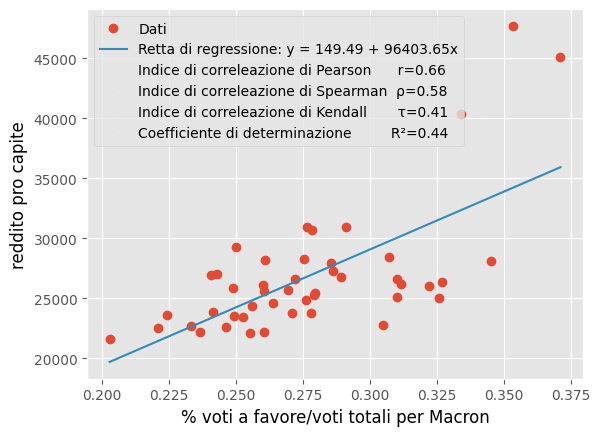

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.66.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a Macron nel primo turno e reddito pro capite.


In [38]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Macron nel primo turno e reddito pro capite?

somma_voti_espressi = df_risultati_elezioni_presidenziali_1_turno.groupby(['nome_dipartimento', 'cognome'], as_index=False)[['voti','espressi']].sum()
somma_voti_espressi = somma_voti_espressi[somma_voti_espressi['cognome'] == 'MACRON']
somma_voti_espressi['% voti_a_favore/voti_totali'] = somma_voti_espressi.apply(percentage_calculator, axis=1)
df_voti_macron = somma_voti_espressi.sort_values(by="% voti_a_favore/voti_totali",ascending=False)
df_voti_macron.reset_index(drop=True, inplace=True)
#display(df_voti_macron)

df_reddito = df_reddito_dipartimenti.sort_values(by="reddito_pro_capite", ascending=False)[['nome_dipartimento', 'reddito_pro_capite']]
df_reddito['reddito_pro_capite'] = df_reddito['reddito_pro_capite'].map(float_converter_2)
df_reddito = df_reddito.astype({"reddito_pro_capite": float})
df_reddito.reset_index(drop=True, inplace=True)
#display(df_reddito)

df_final = pd.merge(df_voti_macron, df_reddito, on='nome_dipartimento')
#display(df_final)

x = df_final['% voti_a_favore/voti_totali']
y = df_final['reddito_pro_capite']

correlation_calculator(x, y, '% voti a favore/voti totali per Macron', 'reddito pro capite')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.66.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a Macron nel primo turno e reddito pro capite.')

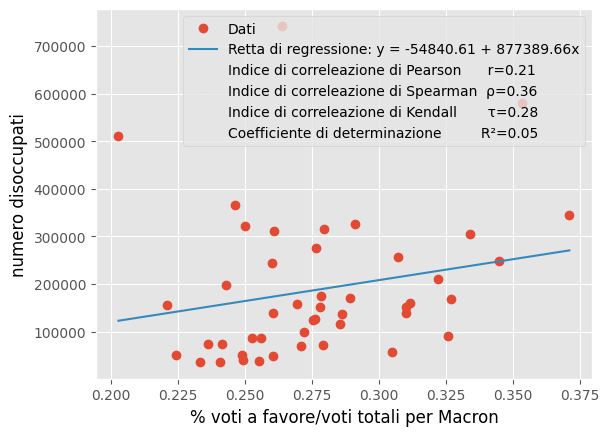

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.21.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Macron nel primo turno e numero di disoccupati.


In [40]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Macron nel primo turno e disoccupazione?

somma_voti_espressi = df_risultati_elezioni_presidenziali_1_turno.groupby(['nome_dipartimento', 'cognome'], as_index=False)[['voti','espressi']].sum()
somma_voti_espressi = somma_voti_espressi[somma_voti_espressi['cognome'] == 'MACRON']
somma_voti_espressi['% voti_a_favore/voti_totali'] = somma_voti_espressi.apply(percentage_calculator, axis=1)
df_voti_macron = somma_voti_espressi.sort_values(by="% voti_a_favore/voti_totali",ascending=False)
df_voti_macron.reset_index(drop=True, inplace=True)
#display(df_voti_macron)

primo_trimestre = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter == 1)]
primo_trimestre_sum = primo_trimestre.groupby('nome_dipartimento')['numero_medio_persone_cercanti_lavoro'].sum()
trimestri_successivi = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter > 1)]
trimestri_successivi_sum = trimestri_successivi.groupby('nome_dipartimento')['differenza_con_cercanti_lavoro_trimestre_prec'].sum()
risultato = pd.merge(primo_trimestre_sum, trimestri_successivi_sum, on='nome_dipartimento')
risultato['disoccupazione_totale'] = risultato['numero_medio_persone_cercanti_lavoro'] + risultato['differenza_con_cercanti_lavoro_trimestre_prec']
df_final_disoccupazione = risultato.reset_index()
#display(df_final_disoccupazione)

df_final = pd.merge(df_voti_macron, df_final_disoccupazione, on='nome_dipartimento')
#display(df_final)

x = df_final['% voti_a_favore/voti_totali']
y = df_final['disoccupazione_totale']

correlation_calculator(x, y, '% voti a favore/voti totali per Macron', 'numero disoccupati')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.21.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Macron nel primo turno e numero di disoccupati.')

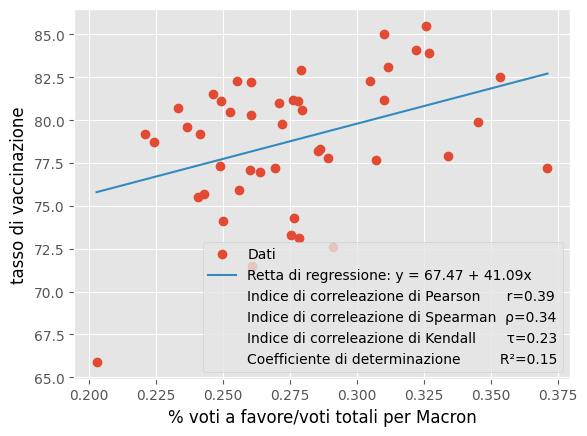

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.21.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Macron nel primo turno e numero di disoccupati.


In [47]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Macron nel primo turno e tasso di vaccinazione?

somma_voti_espressi = df_risultati_elezioni_presidenziali_1_turno.groupby(['nome_dipartimento', 'cognome'], as_index=False)[['voti','espressi']].sum()
somma_voti_espressi = somma_voti_espressi[somma_voti_espressi['cognome'] == 'MACRON']
somma_voti_espressi['% voti_a_favore/voti_totali'] = somma_voti_espressi.apply(percentage_calculator, axis=1)
df_voti_macron = somma_voti_espressi.sort_values(by="% voti_a_favore/voti_totali",ascending=False)
df_voti_macron.reset_index(drop=True, inplace=True)
#display(df_voti_macron)

dati_tutte_eta = df_vaccinazioni_covid[df_vaccinazioni_covid['etichetta_variabile'] == 'Tous âges']
df_copertura_dipartimento = dati_tutte_eta.groupby(['nome_dipartimento'], as_index=False)['copertura_vaccinale_seconda_dose'].max()
#display(df_copertura_dipartimento)

df_final = pd.merge(df_voti_macron, df_copertura_dipartimento, on='nome_dipartimento')
#display(df_final)

x = df_final['% voti_a_favore/voti_totali']
y = df_final['copertura_vaccinale_seconda_dose']

correlation_calculator(x, y, '% voti a favore/voti totali per Macron', 'tasso di vaccinazione')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.39.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Macron nel primo turno e numero di disoccupati.')

In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Le Pen nel primo turno e reddito dichiarato pro capite?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Le Pen nel primo turno e disoccupazione?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Le Pen nel primo turno e tasso di vaccinazione?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Melenchon nel primo turno e reddito dichiarato pro capite?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Melenchon nel primo turno e disoccupazione?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Melenchon nel primo turno e tasso di vaccinazione?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Ensemble/RN/Nupes/LR nel primo turno delle legislative e reddito pro capite?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Ensemble/RN/Nupes/LR nel primo turno delle legislative e disoccupazione?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra voto a Ensemble/RN/Nupes/LR nel primo turno delle legislative e tasso di vaccinazione?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra tasso di vaccinazione e reddito dichiarato pro capite?


In [ ]:
# Esiste una correlazione, in un dato dipartimento, tra tasso di vaccinazione e tasso di disoccupazione?


In [ ]:
# Esistono altre correlazioni, anche spurie?
